# Análise utilizando os autovalores da matriz Laplaciana

O segundo menor autovalor da matriz Laplaciana do grafo também é chamado de conectividade algébrica e possui propriedades interessantes sobre a conectividade do grafo. Ao invés de considerar apenas o segundo menor, podemos considerar um range $[2,...]$ para uma representação de maior dimensão para cada grafo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time
import torch
import pickle
import parkinson
import optuna

import numpy as np
import pandas as pd
import networkx as nx
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn
from joblib import Parallel, delayed
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import RandomOverSampler

/home/vitor/Documents/Parkinson-Diagnosis-Deeplearning/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
RDN = 42
N_CLASSES = 2
BATCH_SIZE = 4
N_EPOCHS = 200
PATIENCE = 20
LR = 0.0001

## Processamento dos dados

In [4]:
# lendo os arquivos de dados
parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
control_data = parkinson.utils.data.batch_read('../data/Controls_columns') 
prodomal_data =  parkinson.utils.data.batch_read('../data/Prodomals_columns') 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.09it/s]


Checando as colunas que aparecem no dataset Control para Shen_268 e renomeando

In [5]:
for i in range(len(control_data)):
    df = control_data[i]
    replace_dict = {
        column: column.replace('shen-268', 'Shen_268').replace('shen 268', 'Shen_268').replace('Shen-268', 'Shen_268')
        for column in df.columns
    }
    control_data[i] = df.rename(columns=replace_dict)

Selecionando o Atlas AAL3

In [6]:
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')
prodomal_atlas_data = parkinson.utils.data.select_atlas_columns(prodomal_data, 'AAL3')

## Abordagem inicial Pearson + Grafo Esparso utilizando Threshold

In [13]:
parkinson_correlation_matrix = parkinson.utils.correlation.pearson_correlation(parkinson_atlas_data, return_upper_triangular=False)
control_correlation_matrix = parkinson.utils.correlation.pearson_correlation(control_atlas_data, return_upper_triangular=False)
prodomal_correlation_matrix = parkinson.utils.correlation.pearson_correlation(prodomal_atlas_data, return_upper_triangular=False)

In [15]:
def get_sparse_adjacency_matrix(correlation_matrix: np.array, threshold: float = 0.01):
    a = correlation_matrix.copy()
    N = len(a)
    a[np.abs(a) < threshold] = 0
    a[np.abs(a) > threshold] = 1
    a -= np.eye(N)
    return sp.sparse.csr_matrix(a)

In [16]:
correlation_matrices = parkinson.utils.data.concatenate_data(parkinson_correlation_matrix, control_correlation_matrix, prodomal_correlation_matrix)

In [17]:
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))], [2 for _ in range(len(prodomal_data))])

In [18]:
correlation_matrices = parkinson.utils.data.concatenate_data(parkinson_correlation_matrix, control_correlation_matrix, prodomal_correlation_matrix)
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))], [2 for _ in range(len(prodomal_data))])
correlation_matrices, y = parkinson.utils.data.filter_data(correlation_matrices, y)

In [28]:
connectivity_graphs = [
    get_sparse_adjacency_matrix(matrix, threshold=0.2) for matrix in correlation_matrices
]

In [29]:
graph_laplacians = [
    sp.sparse.csgraph.laplacian(matrix, normed=True)
    for matrix in connectivity_graphs
]

Considerando os 9 menores autovalores

In [30]:
graph_connectivity = [
    sp.sparse.linalg.eigs(laplacian, which='SR', k=10)[0][1:10].real
    for laplacian in tqdm(graph_laplacians)
]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 407/407 [00:03<00:00, 103.79it/s]


<Axes: >

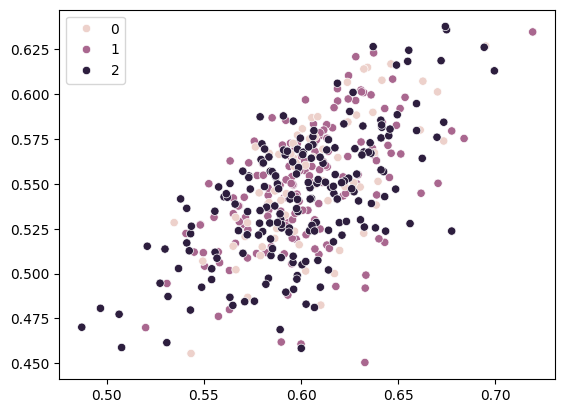

In [31]:
sns.scatterplot(
    x=np.array(graph_connectivity)[:, 1],
    y=np.array(graph_connectivity)[:, 0],
    hue=y
)

### Classificação

In [32]:
# Dividindo os dados em 60 para treino, 20 para validação e 20 para teste
X_train, X_test, y_train, y_test = train_test_split(graph_connectivity, y, test_size=0.1, random_state=RDN, stratify=y, shuffle=True)

In [33]:
optimized_params = {'C': 1, 'coef0': 0, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}

classifier = SVC(class_weight='balanced', **optimized_params, random_state=RDN)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
classifier.predict(X_test)

array([2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 2, 2, 2, 1, 1,
       0, 1, 2, 2, 0, 0, 2, 0, 2, 1, 0, 2, 2, 1, 2, 0, 2, 1, 1])

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.30      0.43      0.35         7
           1       0.35      0.40      0.38        15
           2       0.50      0.37      0.42        19

    accuracy                           0.39        41
   macro avg       0.38      0.40      0.38        41
weighted avg       0.41      0.39      0.39        41



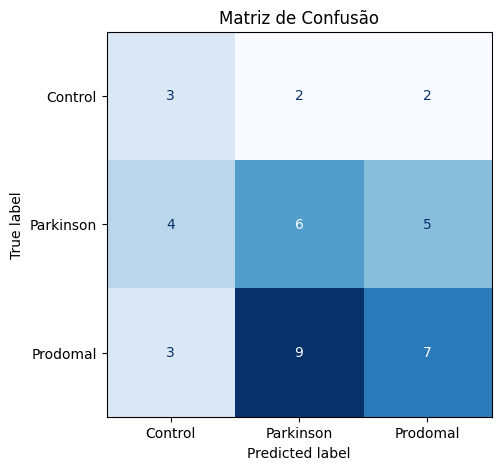

In [35]:
confusion_matrix = parkinson.utils.results.plot_confusion_matrix(y_pred, y_test, class_names=['Control', 'Parkinson', 'Prodomal'])

## Classificação utilizando OMST

O processamento é diferente, portanto decidi deixar em uma parte específica do Notebook

In [38]:
parkinson_correlation_matrix = parkinson.utils.correlation.pearson_correlation(parkinson_atlas_data, return_upper_triangular=False)
control_correlation_matrix = parkinson.utils.correlation.pearson_correlation(control_atlas_data, return_upper_triangular=False)
prodomal_correlation_matrix = parkinson.utils.correlation.pearson_correlation(prodomal_atlas_data, return_upper_triangular=False)

In [39]:
correlation_matrices = parkinson.utils.data.concatenate_data(parkinson_correlation_matrix, control_correlation_matrix, prodomal_correlation_matrix)
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))], [2 for _ in range(len(prodomal_data))])
correlation_matrices, y = parkinson.utils.data.filter_data(correlation_matrices, y)

In [40]:
omst_graphs = [
    parkinson.graph.OMSTBuilder(matrix).build(verbose=False) for matrix in tqdm(correlation_matrices)
]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 407/407 [03:06<00:00,  2.18it/s]


In [41]:
graph_laplacians = [
    sp.sparse.csgraph.laplacian(nx.adjacency_matrix(matrix), normed=True)
    for matrix in omst_graphs
]

In [42]:
graph_connectivity = [
    sp.sparse.linalg.eigs(laplacian, which='SR', k=10)[0][1:10].real
    for laplacian in tqdm(graph_laplacians)
]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 407/407 [00:03<00:00, 116.88it/s]


In [43]:
# Dividindo os dados em 60 para treino, 20 para validação e 20 para teste
X_train, X_test, y_train, y_test = train_test_split(graph_connectivity, y, test_size=0.2, random_state=RDN, stratify=y, shuffle=True)

In [47]:
optimized_params = {'C': 2, 'coef0': 5, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'}

classifier = SVC(class_weight='balanced')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_pred

array([1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.35      0.71      0.47        31
           2       0.39      0.18      0.25        38

    accuracy                           0.35        82
   macro avg       0.25      0.30      0.24        82
weighted avg       0.31      0.35      0.29        82



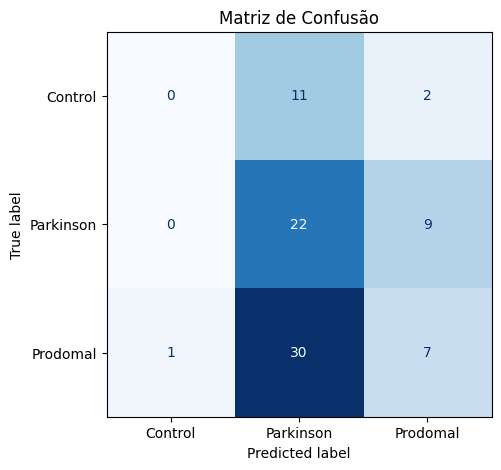

In [48]:
print(classification_report(y_test, y_pred))
confusion_matrix = parkinson.utils.results.plot_confusion_matrix(y_pred, y_test, class_names=['Control','Parkinson', 'Prodomal'])

### Otimização de Hiperparametros com Optuna

In [52]:
def objective(trial):
    # 2. Suggest values for the hyperparameters using a trial object.

    C = trial.suggest_float('C', 1e-10, 1e2, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    degree = trial.suggest_int('degree', 1, 4)
    coef0 = trial.suggest_int('coef0', -10, 10)

    classifier = SVC(
        class_weight='balanced',
        gamma=gamma,
        degree=degree,
        coef0=coef0,
        kernel='poly',
        C=C,
        random_state=RDN
    )

    scores = np.mean(cross_val_score(classifier, X=X_train, y=y_train, cv=10, scoring='f1_weighted'))

    return scores

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

In [54]:
best_params = study.best_params
best_params

{'C': 94.86155630173045, 'gamma': 'scale', 'degree': 4, 'coef0': 8}

In [55]:
classifier = SVC(class_weight={0:2, 1:2, 2:3}, **best_params)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_pred

array([1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2,
       2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 0, 2, 2, 1])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.45      0.32      0.38        31
           2       0.46      0.71      0.56        38

    accuracy                           0.45        82
   macro avg       0.30      0.34      0.31        82
weighted avg       0.38      0.45      0.40        82



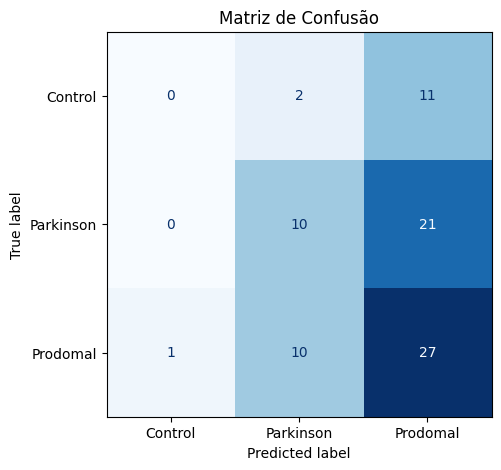

In [56]:
print(classification_report(y_test, y_pred))
confusion_matrix = parkinson.utils.results.plot_confusion_matrix(y_pred, y_test, class_names=['Control','Parkinson', 'Prodomal'])

## Conectividade Contínua

In [57]:
def get_continuous_connectivity(correlation_matrices: list[np.array]) -> list[np.array]:
    threshold_list = np.arange(0.1, 0.35, 0.025)

    continuous_graph_connectivity = []

    for threshold in tqdm(threshold_list):
        connectivity_graphs = [
            get_sparse_adjacency_matrix(matrix, threshold=threshold) for matrix in correlation_matrices
        ]

        graph_laplacians = [
            sp.sparse.csgraph.laplacian(matrix, normed=True)
            for matrix in connectivity_graphs
        ]

        graph_connectivity = [
            sp.sparse.linalg.eigs(laplacian, which='SR', k=2)[0][1].real
            for laplacian in graph_laplacians
        ]

        continuous_graph_connectivity.append(graph_connectivity)

    return np.array(continuous_graph_connectivity).T

In [58]:
correlation_matrices = parkinson.utils.data.concatenate_data(parkinson_correlation_matrix, control_correlation_matrix, prodomal_correlation_matrix)
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))], [2 for _ in range(len(prodomal_data))])
correlation_matrices, y = parkinson.utils.data.filter_data(correlation_matrices, y)

In [59]:
continuous_graph_connectivity = get_continuous_connectivity(correlation_matrices)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.81s/it]


In [62]:
# Dividindo os dados em 60 para treino, 20 para validação e 20 para teste
X_train, X_test, y_train, y_test = train_test_split(continuous_graph_connectivity, y, test_size=0.1, random_state=RDN, stratify=y, shuffle=True)

In [63]:
ros = RandomOverSampler(random_state=42, sampling_strategy='minority')

X_train, y_train = ros.fit_resample(X_train, y_train)

In [67]:
optimized_params = {'C': 0.01, 'coef0': -1, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}

classifier = SVC(**optimized_params, random_state=RDN)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_pred

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00        15
           2       0.46      0.95      0.62        19

    accuracy                           0.44        41
   macro avg       0.15      0.32      0.21        41
weighted avg       0.21      0.44      0.29        41



/home/vitor/Documents/Parkinson-Diagnosis-Deeplearning/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vitor/Documents/Parkinson-Diagnosis-Deeplearning/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vitor/Documents/Parkinson-Diagnosis-Deeplearning/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

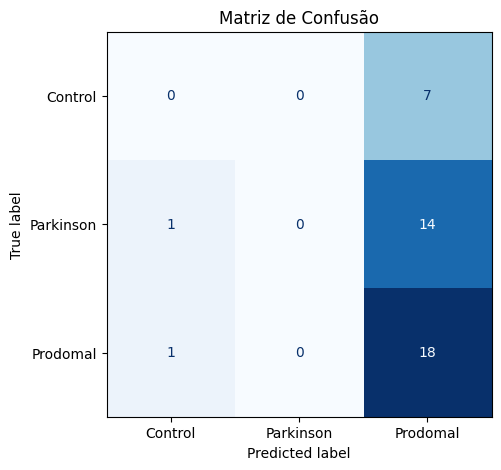

In [68]:
print(classification_report(y_test, y_pred))
confusion_matrix = parkinson.utils.results.plot_confusion_matrix(y_pred, y_test, class_names=['Control','Parkinson', 'Prodomal'])